In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

# Boat Type Classification using CNN and MobileNetV2

This notebook walks through a deep learning project for classifying boat types from images. We will build, train, and evaluate two models: a custom Convolutional Neural Network (CNN) and a transfer learning model using MobileNetV2.

In [ ]:
import os
import shutil
import random

# Step 0: Split Dataset into Train, Validation, and Test sets
base_dir = '../boat_type_classification_dataset'  # Ensure this path is correct
output_dir = './data'

# Create directories for train, validation, and test sets
train_dir = os.path.join(output_dir, 'train')
validation_dir = os.path.join(output_dir, 'validation')
test_dir = os.path.join(output_dir, 'test')

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

os.makedirs(train_dir)
os.makedirs(validation_dir)
os.makedirs(test_dir)

# Get the list of classes (boat types)
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and len(os.listdir(os.path.join(base_dir, d))) > 0]

random.seed(42)  # Ensure reproducibility

for cls in classes:
    # Create subdirectories for each class in train, validation, and test
    os.makedirs(os.path.join(train_dir, cls))
    os.makedirs(os.path.join(validation_dir, cls))
    os.makedirs(os.path.join(test_dir, cls))

    # Get all image file names for the class
    src_dir = os.path.join(base_dir, cls)
    all_files = [f for f in os.listdir(src_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(all_files)

    if not all_files:
        print(f"Skipping empty class directory: {cls}")
        continue

    # Define split ratios
    train_ratio = 0.7
    validation_ratio = 0.15
    test_ratio = 0.15

    # Calculate split indices
    train_split = int(len(all_files) * train_ratio)
    validation_split = int(len(all_files) * (train_ratio + validation_ratio))

    # Get file lists for each set
    train_files = all_files[:train_split]
    validation_files = all_files[train_split:validation_split]
    test_files = all_files[validation_split:]

    # Function to copy files
    def copy_files(files, dest_dir):
        for f in files:
            try:
                shutil.copy(os.path.join(src_dir, f), os.path.join(dest_dir, cls, f))
            except Exception as e:
                print(f"Error copying file {f}: {e}")

    # Copy files to their respective directories
    copy_files(train_files, train_dir)
    copy_files(validation_files, validation_dir)
    copy_files(test_files, test_dir)

print("Dataset successfully split into train, validation, and test sets.")
print(f"Total classes: {len(classes)}")

Dataset successfully split into train, validation, and test sets.
Total classes: 9
Dataset successfully split into train, validation, and test sets.
Total classes: 9


### 1.2 Split the Dataset

To ensure our model is evaluated correctly, we split the dataset into three parts:
- **Training set (70%)**: Used to train the model.
- **Validation set (15%)**: Used to tune hyperparameters and evaluate the model during training.
- **Test set (15%)**: Used to provide an unbiased evaluation of the final model.

This helps prevent data leakage and gives a more accurate measure of the model's performance on unseen data.

### 1.1 Import Libraries

This cell imports all the necessary libraries for the project, including:
- `numpy` for numerical operations.
- `tensorflow` and `keras` for building and training the deep learning models.
- `matplotlib` and `seaborn` for plotting graphs and visualizations.
- `sklearn` for performance metrics and utility functions.
- `os`, `shutil`, and `random` for file and directory operations.

### 3.3 Evaluate the MobileNetV2 Model

We evaluate the MobileNetV2 model on the test set, just as we did for the CNN.

## 4. Compare Models and Visualize Results

Let's compare the performance of both models and visualize their training history.

In [ ]:
def plot_history(history, title):
    """Plot training and validation accuracy and loss"""
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot training history for both models
plot_history(history_cnn, 'Custom CNN')
plot_history(history_mobilenet, 'MobileNetV2')

In [ ]:
# Final comparison of models
print("="*70)
print("📊 FINAL MODEL COMPARISON")
print("="*70)
print(f"Custom CNN Test Accuracy:      {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"MobileNetV2 Test Accuracy:     {test_acc_mobilenet:.4f} ({test_acc_mobilenet*100:.2f}%)")
print("="*70)

# Determine the best model
if test_acc_mobilenet > test_acc:
    best_model = 'MobileNetV2'
    best_accuracy = test_acc_mobilenet
    improvement = (test_acc_mobilenet - test_acc) * 100
    print(f"\n🏆 Best Model: {best_model}")
    print(f"   Improvement over CNN: +{improvement:.2f}%")
else:
    best_model = 'Custom CNN'
    best_accuracy = test_acc
    print(f"\n🏆 Best Model: {best_model}")

print("="*70)

In [ ]:
# Save the best model
if test_acc_mobilenet > test_acc:
    model_save_path = 'boat_classifier_mobilenet.h5'
    mobilenet_model.save(model_save_path)
    print(f"✅ Best model (MobileNetV2) saved to {model_save_path}")
else:
    model_save_path = 'boat_classifier_cnn.h5'
    cnn_model.save(model_save_path)
    print(f"✅ Best model (Custom CNN) saved to {model_save_path}")

print(f"   Model can now be used for deployment!")

In [15]:
# Train the model
history_mobilenet = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.1948 - loss: 2.5750 - val_accuracy: 0.3121 - val_loss: 2.0286
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.1948 - loss: 2.5750 - val_accuracy: 0.3121 - val_loss: 2.0286
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3576 - loss: 1.8906 - val_accuracy: 0.5202 - val_loss: 1.6904
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3576 - loss: 1.8906 - val_accuracy: 0.5202 - val_loss: 1.6904
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5586 - loss: 1.4453 - val_accuracy: 0.6185 - val_loss: 1.4143
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5586 - loss: 1.4453 - val_accuracy: 0.6185 - val_loss: 1.4143
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5968 - loss: 1.2609 - val_accuracy: 0.6994 - val_loss: 1.2101
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5968 - loss: 1.2609 - val_accuracy: 0.6994 - val_loss:

### 3.2 Train the MobileNetV2 Model

We train this model similarly to the CNN, but we don't need `class_weights` here, as transfer learning models are often more robust to imbalance.

In [14]:
# Load the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
mobilenet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,513 (10.00 MB)

 Trainable params: 362,761 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

## 3. Build and Train MobileNetV2 Model (Transfer Learning)

Next, we'll use a pre-trained model, **MobileNetV2**, for transfer learning. This approach leverages a model that has already been trained on a massive dataset (ImageNet) and adapts it for our specific task.

### 3.1 Load the Pre-trained Model

We load MobileNetV2 without its final classification layer (`include_top=False`) and freeze its weights (`trainable=False`) so that we only train our custom layers.

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.0281 - loss: 2.2281
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.0281 - loss: 2.2281
CNN Test Accuracy: 0.0281
CNN Test Accuracy: 0.0281
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 931ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 931ms/step

Classification Report:

Classification Report:
                 precision    recall  f1-score   support

           buoy       0.04      0.62      0.07         8
    cruise_ship       0.00      0.00      0.00        29
     ferry_boat       0.00      0.00      0.00        10
   freight_boat       0.00      0.00      0.00         4
        gondola       0.00      0.00      0.00        29
inflatable_boat       0.00      0.00      0.00         3
          kayak       0.00      0.00      0.00        31
     paper_boat       0.00      0.00      0.00         5
       sailboat       0.00      0.00      0.00        59

       accuracy                           0.03       178
      macro avg       0.00      0.07      0.01       

C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

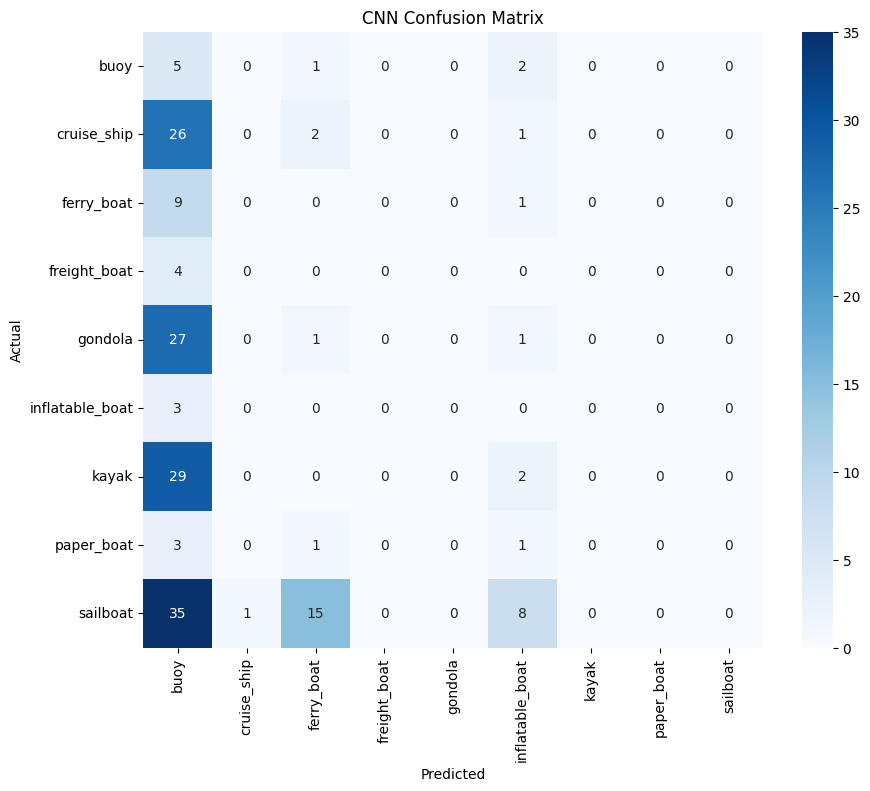

In [13]:
# Evaluate on the test set
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f"CNN Test Accuracy: {test_acc:.4f}")

# Get predictions
y_pred = np.argmax(cnn_model.predict(test_generator), axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN Confusion Matrix')
plt.show()

### 2.3 Evaluate the CNN Model

After training, we evaluate the model's performance on the unseen test set. We'll look at:
- **Test Accuracy**: The overall percentage of correct predictions.
- **Classification Report**: A detailed breakdown of precision, recall, and F1-score for each class.
- **Confusion Matrix**: A visual representation of the model's predictions, showing where it gets confused.

In [12]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Increased epochs, but early stopping will prevent overfitting
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 245s 9s/step - accuracy: 0.1714 - loss: 2.6505 - val_accuracy: 0.0520 - val_loss: 2.2236
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 245s 9s/step - accuracy: 0.1714 - loss: 2.6505 - val_accuracy: 0.0520 - val_loss: 2.2236
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 190s 7s/step - accuracy: 0.2145 - loss: 2.4560 - val_accuracy: 0.0289 - val_loss: 2.2656
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 190s 7s/step - accuracy: 0.2145 - loss: 2.4560 - val_accuracy: 0.0289 - val_loss: 2.2656
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 215s 8s/step - accuracy: 0.1887 - loss: 2.2366 - val_accuracy: 0.0405 - val_loss: 2.2975
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 215s 8s/step - accuracy: 0.1887 - loss: 2.2366 - val_accuracy: 0.0405 - val_loss: 2.2975
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 173s 7s/step - accuracy: 0.2035 - loss: 2.1958 - val_accuracy: 0.0462 - val_loss: 2.3215
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 173s 7s/step - accuracy: 0.2035 - loss: 2.1958 - val_accuracy: 0.0462 - v

### 2.2 Train the CNN Model

We train the model using the `fit` method.
- **Early Stopping**: We use a callback to stop training if the validation loss doesn't improve for 5 consecutive epochs. This saves time and prevents overfitting.
- **Class Weights**: The `class_weights_dict` is passed to ensure balanced training.

In [11]:
cnn_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation='softmax')  # Use num_classes from generator
])

# Compile the model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,033 (566.54 KB)

 Trainable params: 143,881 (562.04 KB)

 Non-trainable params: 1,152 (4.50 KB)

## 2. Build and Train a Custom CNN Model

Now, we'll build our first model, a custom Convolutional Neural Network (CNN).

### 2.1 Define the CNN Architecture

The model consists of:
- **Convolutional layers (`Conv2D`)**: To extract features like edges and textures.
- **Batch Normalization**: To stabilize and speed up training.
- **Max Pooling layers (`MaxPooling2D`)**: To reduce the spatial dimensions and computational load.
- **Global Average Pooling**: To reduce the feature maps to a single vector per map.
- **Dense layers**: For classification, with `Dropout` to prevent overfitting.
- **Softmax activation**: In the final layer to output probabilities for each of the 9 classes.

In [10]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(2.4354354354354353), 1: np.float64(0.6775271512113618), 2: np.float64(2.047979797979798), 3: np.float64(5.631944444444445), 4: np.float64(0.6674897119341564), 5: np.float64(8.191919191919192), 6: np.float64(0.634585289514867), 7: np.float64(4.291005291005291), 8: np.float64(0.3312908496732026)}


### 1.4 Handle Class Imbalance

Some boat categories might have more images than others. This can bias the model towards the more frequent classes. To address this, we calculate `class_weights` to give more importance to under-represented classes during training.

In [9]:
# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale for validation and test sets
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 811 images belonging to 9 classes.
Found 173 images belonging to 9 classes.
Found 173 images belonging to 9 classes.
Found 178 images belonging to 9 classes.
Found 178 images belonging to 9 classes.


### 1.3 Data Augmentation and Loading

This section prepares the data for training. We use `ImageDataGenerator` to:
- **Rescale** the pixel values from [0, 255] to [0, 1], which is a standard practice for neural networks.
- **Augment** the training data by applying random transformations like rotation, zoom, and flips. This helps the model generalize better and reduces overfitting.
- **Load** the data from the directories we created, resizing images to a standard `(224, 224)` size.